# Quality Control & Preprocessing

Filter low-quality spots, normalize counts, identify highly variable genes, and prepare data for dimensionality reduction and clustering.

In [1]:
# IMPORTS & PATHS 

from __future__ import annotations
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tempfile

# Workaround for Windows Store Python + numba caching: use a writable cache dir
os.environ.setdefault('NUMBA_CACHE_DIR', str(Path(tempfile.gettempdir()) / 'numba_cache'))
Path(os.environ['NUMBA_CACHE_DIR']).mkdir(parents=True, exist_ok=True)

import scanpy as sc
import squidpy as sq

# Make saved PNGs readable in viewers (no transparency / white background)
sc.settings.set_figure_params(dpi=120, facecolor='white', transparent=False)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['savefig.transparent'] = False


sc.settings.verbosity = 3

# Project Root
cwd = Path.cwd().resolve()
if (cwd / 'README.md').exists() and (cwd / 'data').exists():
    project_root = cwd
elif (cwd.parent / 'README.md').exists() and (cwd.parent / 'data').exists():
    project_root = cwd.parent
else:
    raise RuntimeError(f'Cannot locate project root from cwd={cwd}.')

raw_dir       = project_root / 'data' / 'raw'   / 'Visium_Human_Breast_Cancer'
processed_dir = project_root / 'data' / 'processed'
fig_qc_dir    = project_root / 'figures' / 'qc'
fig_sp_dir    = project_root / 'figures' / 'spatial'

for d in [processed_dir, fig_qc_dir, fig_sp_dir]:
    d.mkdir(parents=True, exist_ok=True)

sc.settings.figdir = str(fig_qc_dir)

print(f"Scanpy  : {sc.__version__}")
print(f"Squidpy : {sq.__version__}")
print(f"Raw dir : {raw_dir}")

Scanpy  : 1.12
Squidpy : 1.8.1
Raw dir : C:\Users\mmsid\Documents\github\My Project\spatial_biology_project\data\raw\Visium_Human_Breast_Cancer


In [2]:
# RELOAD ADATA
adata = sc.read_visium(
    path=str(raw_dir),
    count_file='Visium_Human_Breast_Cancer_filtered_feature_bc_matrix.h5',
)
adata.var_names_make_unique()

print(adata)
print(f"\nMatrix type      : {type(adata.X)}")
print(f"Spots on tissue  : {adata.n_obs}")
print(f"Genes detected   : {adata.n_vars}")

# Keep only spots on tissue
print('in_tissue counts:', adata.obs['in_tissue'].value_counts().to_dict())
adata = adata[adata.obs['in_tissue'] == 1].copy()
print('After in_tissue filter:', adata)


reading C:\Users\mmsid\Documents\github\My Project\spatial_biology_project\data\raw\Visium_Human_Breast_Cancer\Visium_Human_Breast_Cancer_filtered_feature_bc_matrix.h5
 (0:00:01)
AnnData object with n_obs × n_vars = 4898 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Matrix type      : <class 'scipy.sparse._csr.csr_matrix'>
Spots on tissue  : 4898
Genes detected   : 36601
in_tissue counts: {1: 4898}
After in_tissue filter: AnnData object with n_obs × n_vars = 4898 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


In [3]:
# ANNOTATE QC METRICS

# Flag mitochondrial genes (MT-) - high MT% = dying/damaged cells
adata.var['mt']   = adata.var_names.str.startswith('MT-')

# Flag ribosomal genes (RPS/RPL) - optional but useful to track
adata.var['ribo'] = adata.var_names.str.startswith(('RPS', 'RPL'))

# Flag hemoglobin genes - contamination check
adata.var['hb']   = adata.var_names.str.contains('^HB[^(P)]', regex=True)

sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=['mt', 'ribo', 'hb'],
    inplace=True,
    percent_top=[20]
)

# Quick summary
print("=" * 55)
print(f"  total_counts   min: {adata.obs['total_counts'].min():.0f}"
      f"   median: {adata.obs['total_counts'].median():.0f}"
      f"   max: {adata.obs['total_counts'].max():.0f}")
print(f"  n_genes        min: {adata.obs['n_genes_by_counts'].min():.0f}"
      f"   median: {adata.obs['n_genes_by_counts'].median():.0f}"
      f"   max: {adata.obs['n_genes_by_counts'].max():.0f}")
print(f"  pct_mt         min: {adata.obs['pct_counts_mt'].min():.2f}"
      f"   mean: {adata.obs['pct_counts_mt'].mean():.2f}"
      f"   max: {adata.obs['pct_counts_mt'].max():.2f}")
print(f"  pct_ribo       mean: {adata.obs['pct_counts_ribo'].mean():.2f}%")
print(f"  pct_hb         mean: {adata.obs['pct_counts_hb'].mean():.2f}%")
print("=" * 55)

  total_counts   min: 164   median: 9720   max: 54830
  n_genes        min: 140   median: 3654   max: 8367
  pct_mt         min: 0.59   mean: 3.71   max: 14.31
  pct_ribo       mean: 15.18%
  pct_hb         mean: 0.01%


In [4]:
# Set the thresholds
# Note: We already filtered to in_tissue==1 earlier.

n_before, g_before = adata.n_obs, adata.n_vars

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, min_counts=500)
sc.pp.filter_genes(adata, min_cells=3)

adata = adata[adata.obs['pct_counts_mt'] < 15].copy()

# Recompute QC metrics after filtering (totals can change after gene filtering)
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=['mt', 'ribo', 'hb'],
    inplace=True,
    percent_top=[20],
)

print(f'After filtering: {n_before} -> {adata.n_obs} spots; {g_before} -> {adata.n_vars} genes')


filtered out 3 cells that have less than 200 genes expressed
filtered out 26 cells that have less than 500 counts
filtered out 15252 genes that are detected in less than 3 cells
After filtering: 4898 -> 4869 spots; 36601 -> 21349 genes


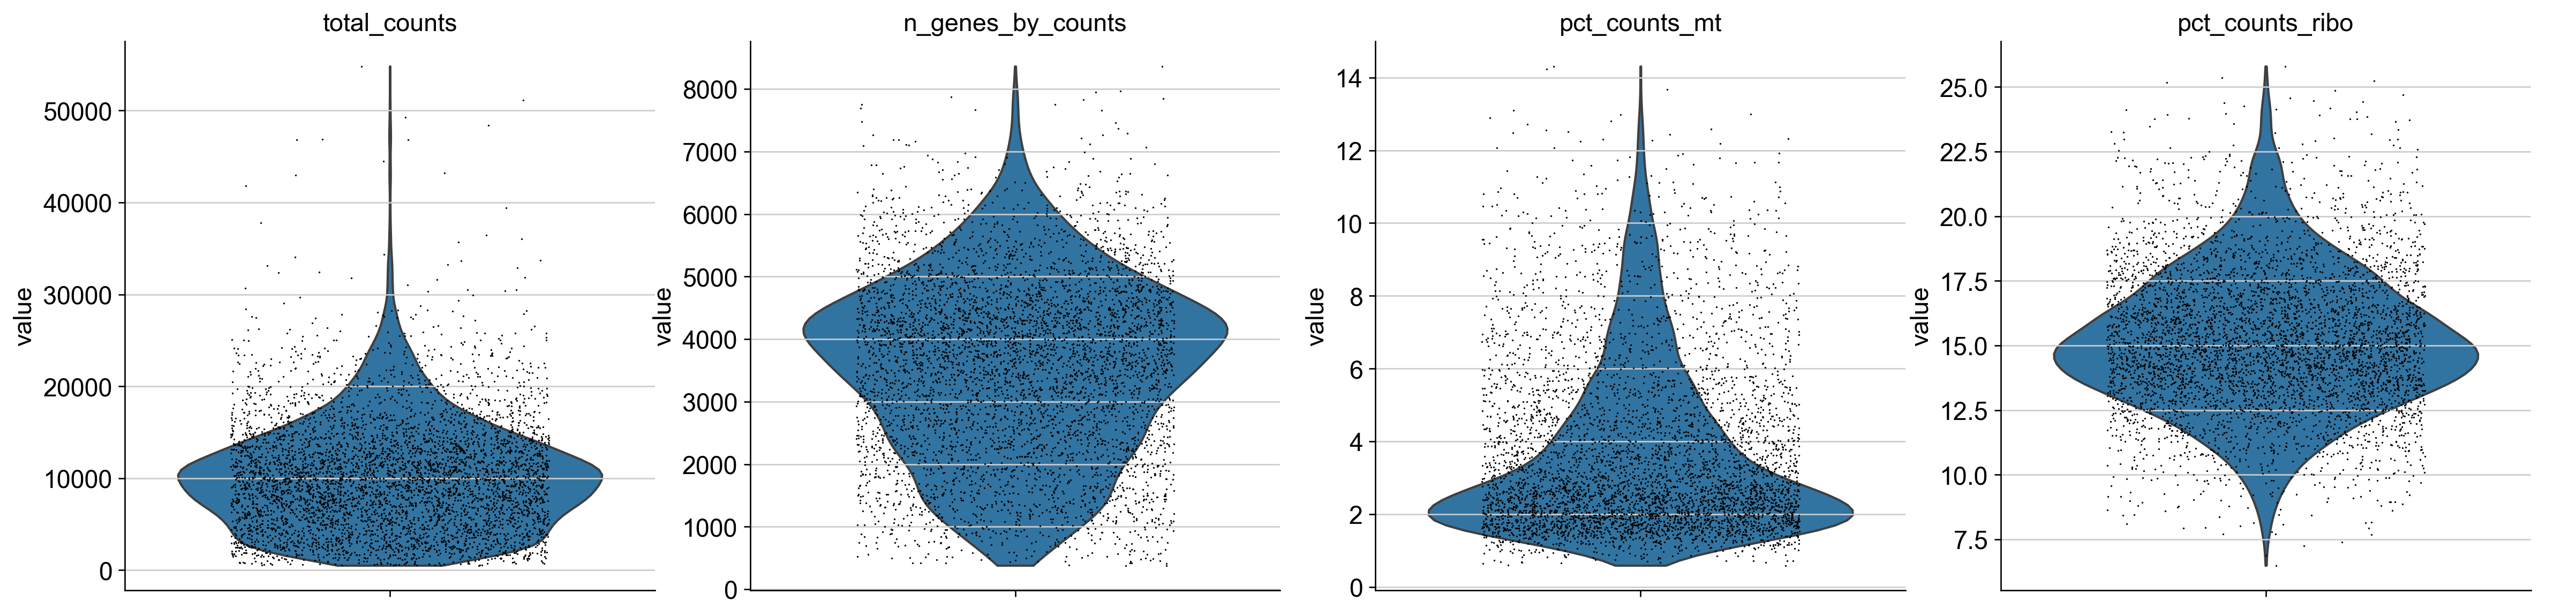

Saved -> figures/qc/violin_01_qc_violin.png


In [5]:
# QC VIOLIN PLOTS 

sc.pl.violin(
    adata,
    keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mt',
          'pct_counts_ribo'],
    multi_panel=True,
    jitter=0.3,
    save='_01_qc_violin.png'
)
print("Saved -> figures/qc/violin_01_qc_violin.png")

In [6]:
# SPATIAL QC OVERLAY
# Visualize metrics on the tissue image

prev_figdir = sc.settings.figdir
sc.settings.figdir = str(fig_sp_dir)

sq.pl.spatial_scatter(
    adata,
    color=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
    ncols=3,
    title=['Total UMI Counts', 'Genes per Spot', 'MT Gene %'],
    save=None,
)

# Save PNG 
out_path = fig_sp_dir / '02_spatial_qc.png'
plt.gcf().savefig(out_path, dpi=200, facecolor='white', edgecolor='white', transparent=False, bbox_inches='tight')
plt.close()

sc.settings.figdir = prev_figdir
print(f'Saved -> {out_path}')


Saved -> C:\Users\mmsid\Documents\github\My Project\spatial_biology_project\figures\spatial\02_spatial_qc.png


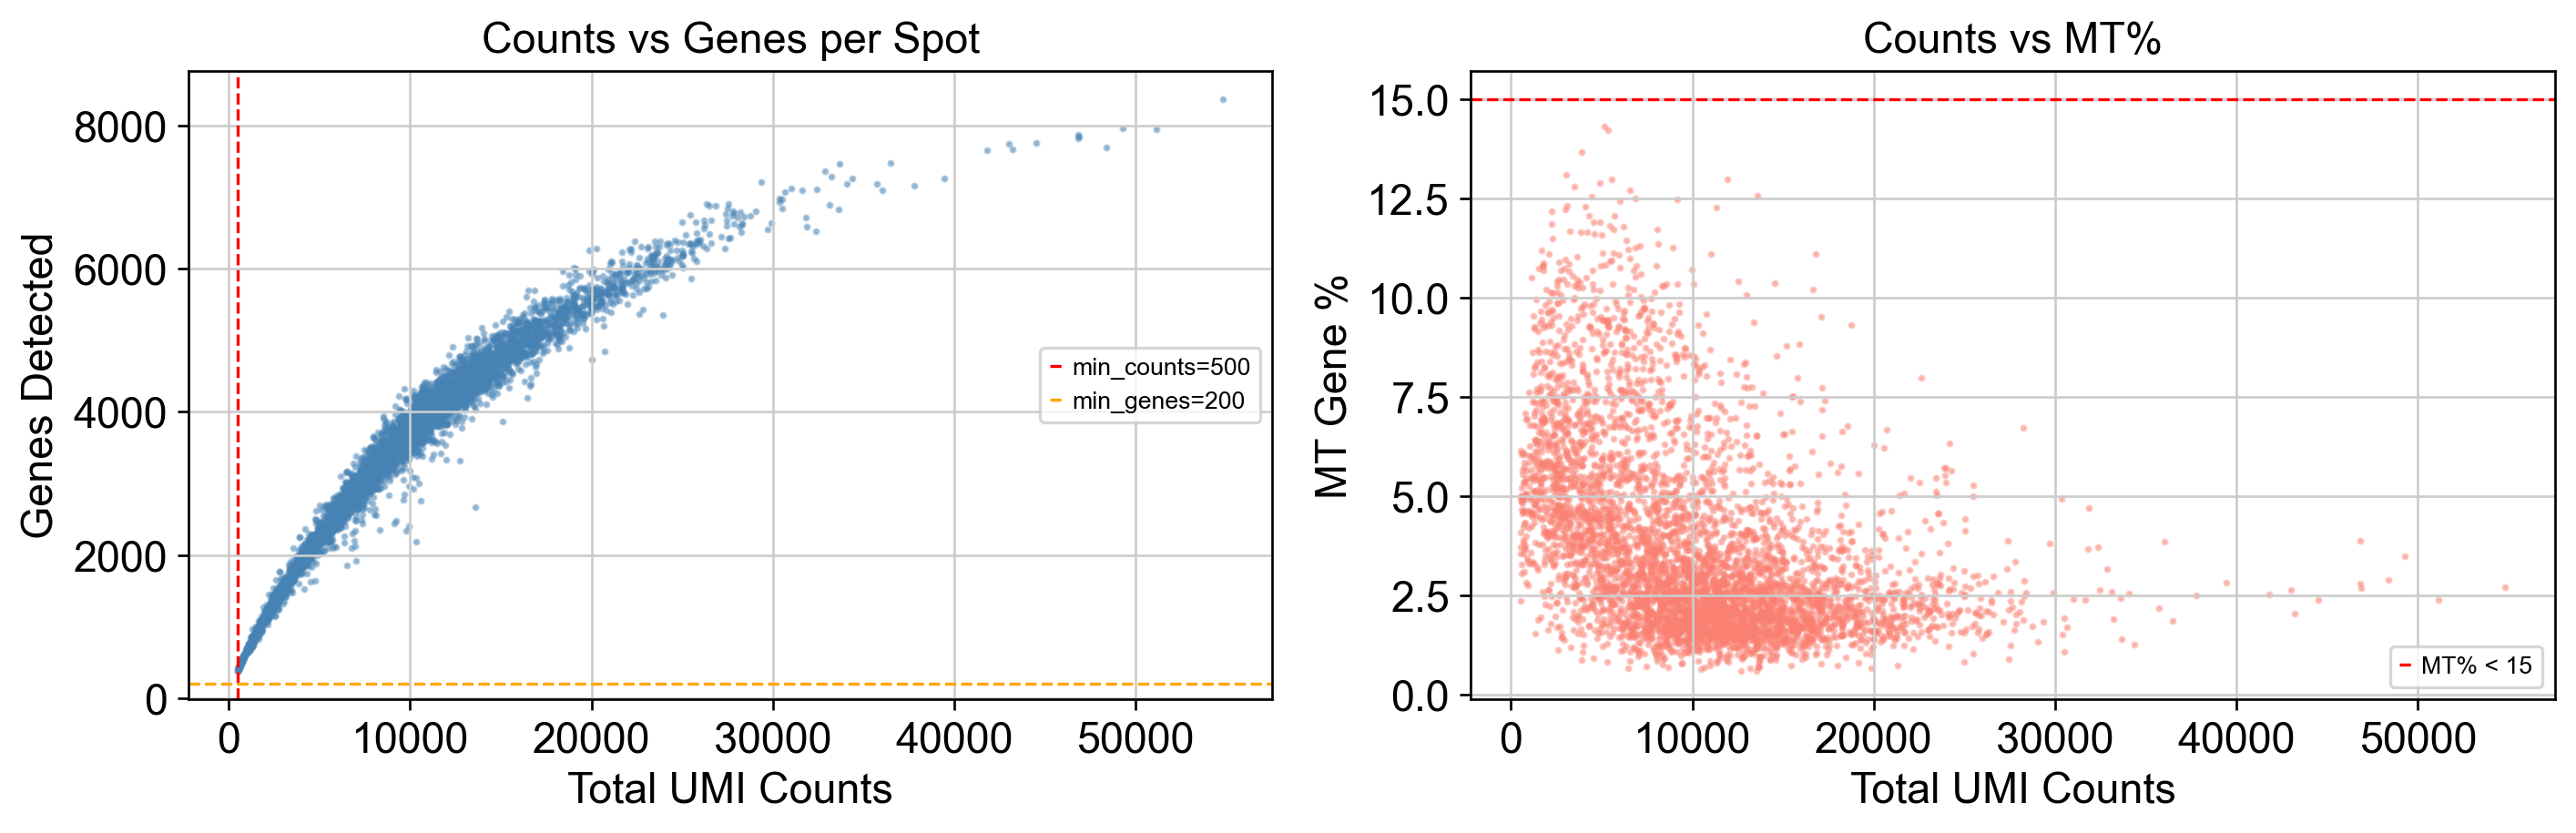

Saved -> figures/qc/03_scatter_qc.png


In [7]:
# SCATTER - COUNTS vs GENES (detect doublets / empty spots) 

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(
    adata.obs['total_counts'],
    adata.obs['n_genes_by_counts'],
    s=2, alpha=0.4, c='steelblue'
)
axes[0].set_xlabel('Total UMI Counts')
axes[0].set_ylabel('Genes Detected')
axes[0].set_title('Counts vs Genes per Spot')
axes[0].axvline(500, color='red',    linestyle='--', linewidth=1, label='min_counts=500')
axes[0].axhline(200,  color='orange', linestyle='--', linewidth=1, label='min_genes=200')
axes[0].legend(fontsize=8)

axes[1].scatter(
    adata.obs['total_counts'],
    adata.obs['pct_counts_mt'],
    s=2, alpha=0.4, c='salmon'
)
axes[1].set_xlabel('Total UMI Counts')
axes[1].set_ylabel('MT Gene %')
axes[1].set_title('Counts vs MT%')
axes[1].axhline(15, color='red', linestyle='--', linewidth=1, label='MT% < 15')
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.savefig(str(fig_qc_dir / '03_scatter_qc.png'), dpi=120, bbox_inches='tight')
plt.show()
print("Saved -> figures/qc/03_scatter_qc.png")

In [12]:
# FILTER (already done above) - quick recap of current shape
print(f'Spots: {adata.n_obs:,}')
print(f'Genes: {adata.n_vars:,}')


Spots: 4,869
Genes: 21,349


In [13]:
# NORMALIZE
# Store raw integer counts BEFORE any transformation (for Cell2Location / deconvolution)
if 'counts' not in adata.layers:
    adata.layers['counts'] = adata.X.copy()
print('Counts layer shape:', adata.layers['counts'].shape)

# Normalize each spot to 10,000 total counts (CPM-like)
sc.pp.normalize_total(adata, target_sum=1e4)

# Log1p transform: log(x + 1)
if 'log1p' not in adata.uns:
    sc.pp.log1p(adata)

# Store log-normalized data in .raw before any gene subsetting
adata.raw = adata

print('Normalization + log1p done')
print(f'X min: {adata.X.min():.3f}  max: {adata.X.max():.3f}')


Counts layer shape: (4869, 21349)
normalizing counts per cell
    finished (0:00:00)
Normalization + log1p done
X min: 0.000  max: 45.667


extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
HVGs selected: 3000 / 21349


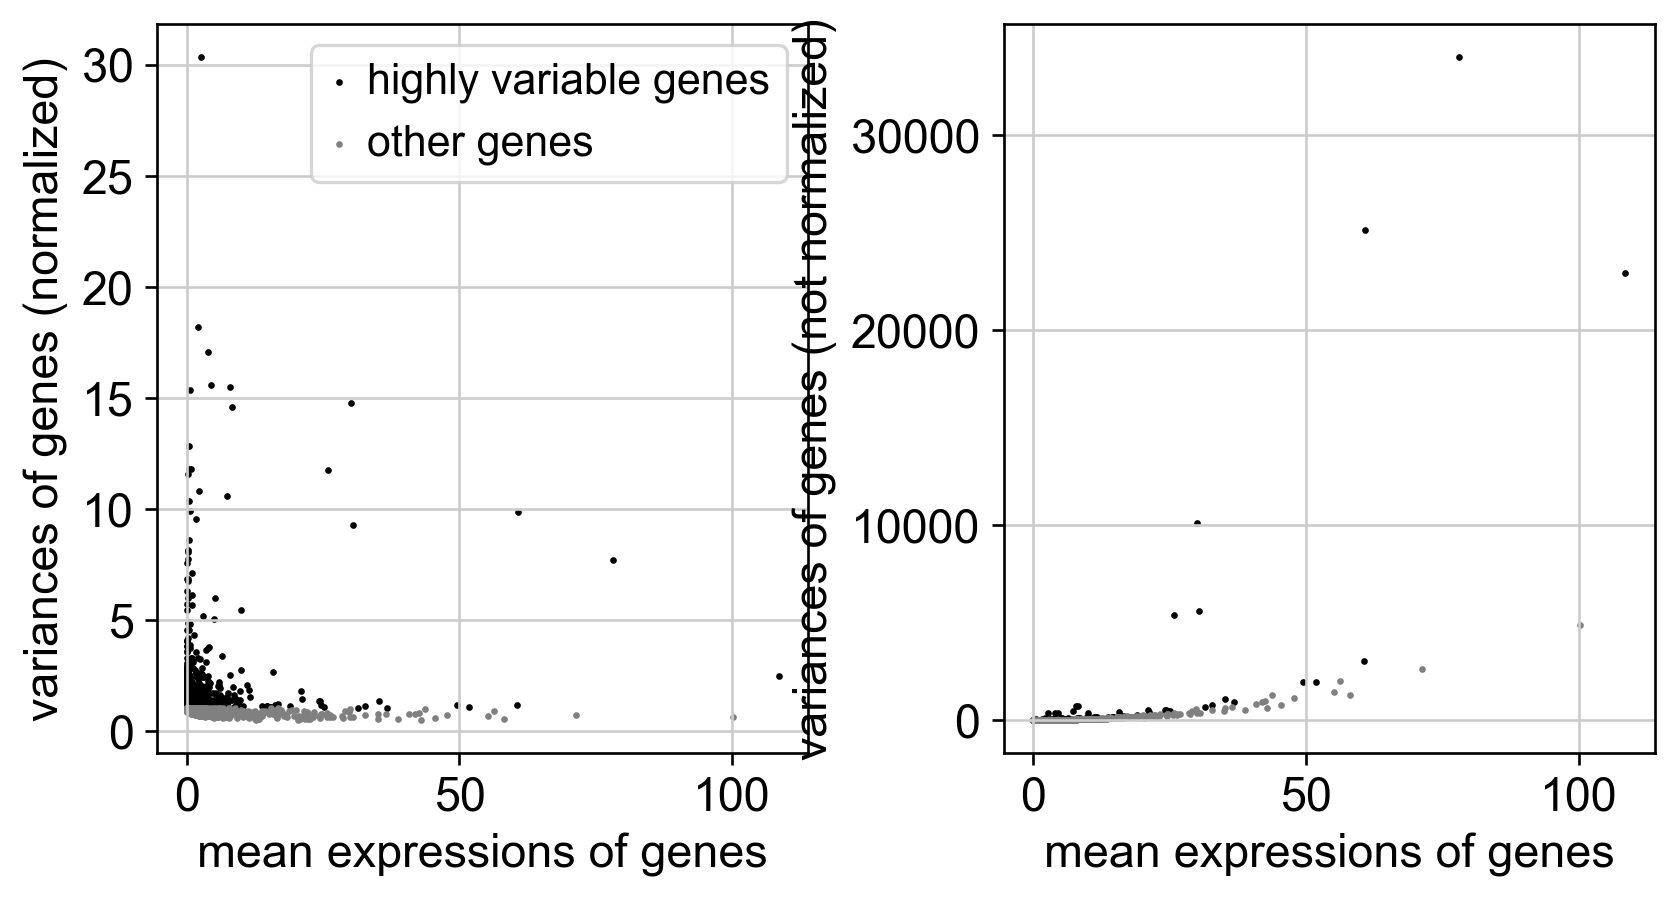

Saved -> figures/qc/highly_variable_genes_04_hvg.png


In [15]:
# HIGHLY VARIABLE GENES

if 'counts' not in adata.layers:
    raise RuntimeError("Missing adata.layers['counts']. Run the NORMALIZE cell first.")

# seurat_v3  (use raw counts; use the counts layer)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    flavor='seurat_v3',
    layer='counts',
    subset=False,
)

n_hvg = int(adata.var['highly_variable'].sum())
print(f'HVGs selected: {n_hvg} / {adata.n_vars}')

sc.pl.highly_variable_genes(adata, save='_04_hvg.png')
print('Saved -> figures/qc/highly_variable_genes_04_hvg.png')


In [17]:
# SCALE 
# Zero-mean, unit-variance per gene (only affects PCA)
# max_value=10 clips extreme outliers
sc.pp.scale(adata, max_value=10)
print("Scaling done")
print(f"   X min: {adata.X.min():.3f}   max: {adata.X.max():.3f}")

Scaling done
   X min: -4.220   max: 10.000


computing PCA
    with n_comps=50
    finished (0:00:04)


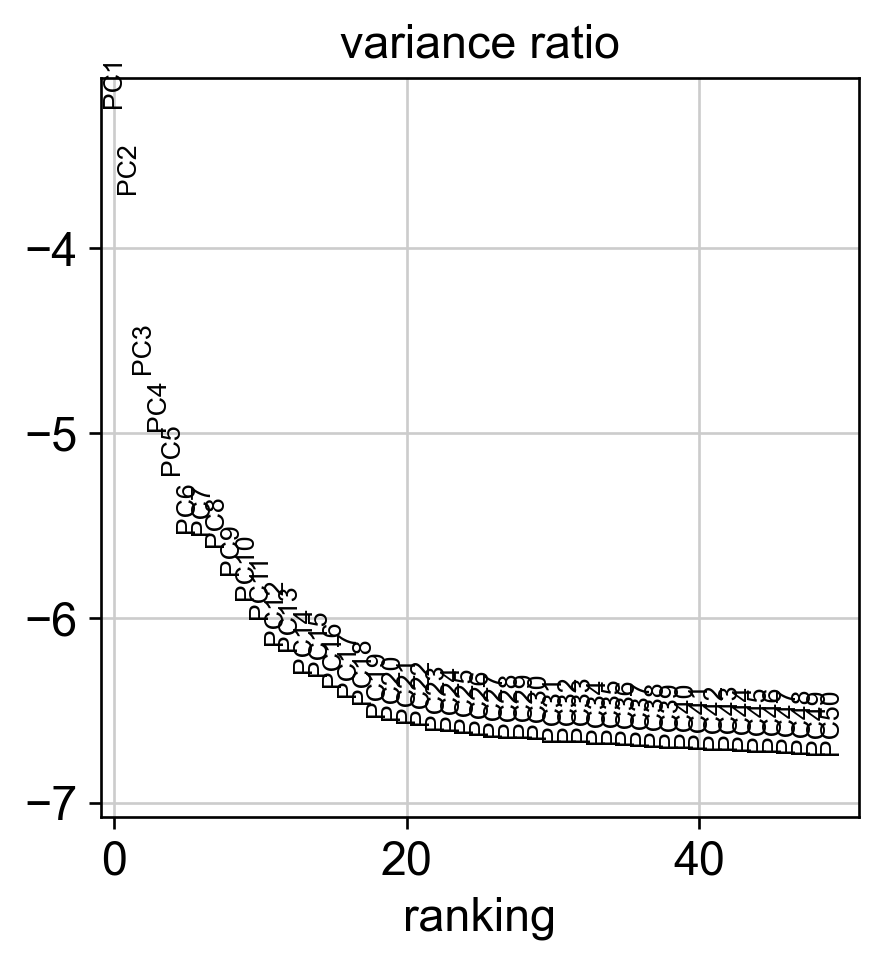


Cumulative variance explained:
  Top 10 PCs : 10.3%
  Top 15 PCs : 11.3%
  Top 20 PCs : 12.1%
  Top 30 PCs : 13.4%
  Top 40 PCs : 14.7%
  Top 50 PCs : 15.9%


In [18]:
# PCA 
sc.tl.pca(adata, n_comps=50, use_highly_variable=True)

# Variance ratio plot - look at the "elbow"
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True,
                          save='_05_pca_variance.png')

# Cumulative variance explained by top PCs
pca_var = adata.uns['pca']['variance_ratio']
cum_var = np.cumsum(pca_var)
print("\nCumulative variance explained:")
for n in [10, 15, 20, 30, 40, 50]:
    print(f"  Top {n:2d} PCs : {cum_var[n-1]*100:.1f}%")

In [20]:
# NEIGHBORHOOD GRAPH + UMAP 
# Set N_PCS after looking at elbow plot above
# Rule: pick where the curve flattens out

N_PCS = 30   # adjusted after elbow plot

sc.pp.neighbors(adata, n_pcs=N_PCS, n_neighbors=15)
sc.tl.umap(adata)

print(f"kNN graph  (n_pcs={N_PCS}, n_neighbors=15)")
print("UMAP computed")

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:11)
kNN graph  (n_pcs=30, n_neighbors=15)
UMAP computed


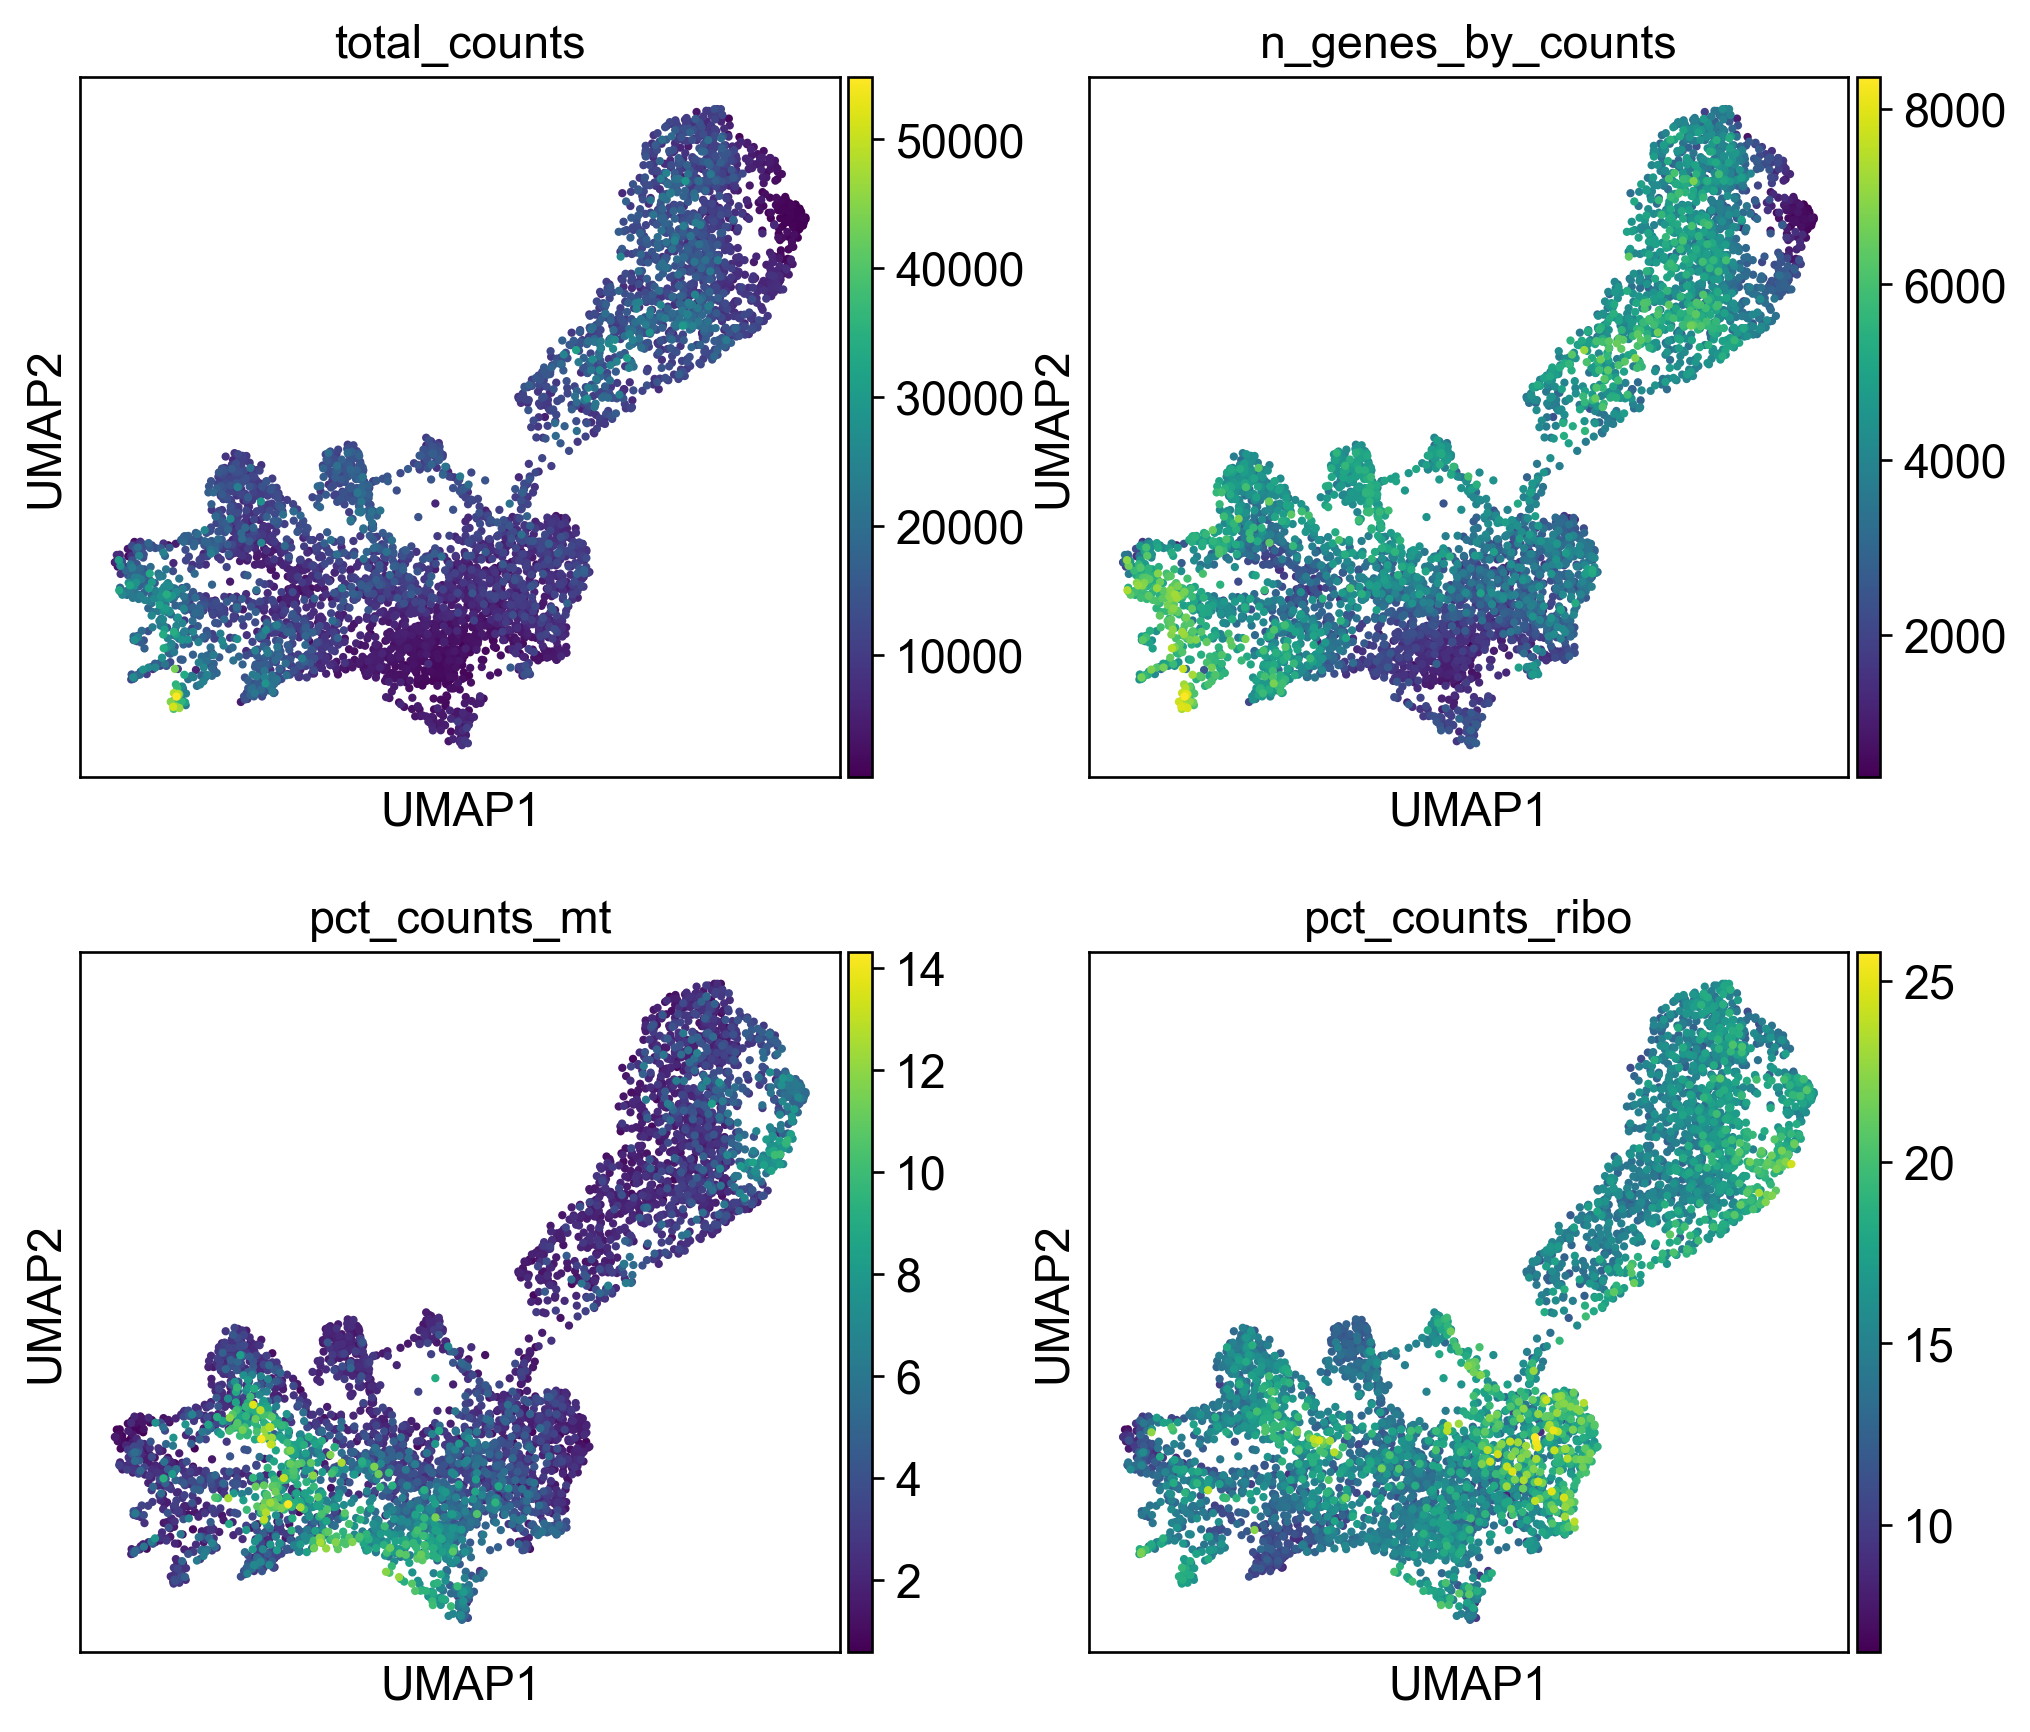

Saved -> figures/qc/umap_06_umap_qc.png


In [21]:
# UMAP - QC FEATURES 
sc.pl.umap(
    adata,
    color=['total_counts', 'n_genes_by_counts', 'pct_counts_mt',
           'pct_counts_ribo'],
    ncols=2,
    save='_06_umap_qc.png'
)
print("Saved -> figures/qc/umap_06_umap_qc.png")

In [23]:
# SPATIAL SCATTER POST-QC
# Visualize metrics on the tissue image

prev_figdir = sc.settings.figdir
sc.settings.figdir = str(fig_sp_dir)

sq.pl.spatial_scatter(
    adata,
    color=['total_counts', 'n_genes_by_counts'],
    ncols=2,
    title=['Total UMI (post-QC)', 'Genes per Spot (post-QC)'],
    save=None,
)

# Save PNG
out_path = fig_sp_dir / '07_spatial_postqc.png'
plt.gcf().savefig(out_path, dpi=200, facecolor='white', edgecolor='white', transparent=False, bbox_inches='tight')
plt.close()

sc.settings.figdir = prev_figdir
print(f'Saved -> {out_path}')


Saved -> C:\Users\mmsid\Documents\github\My Project\spatial_biology_project\figures\spatial\07_spatial_postqc.png


In [24]:
# SAVE PROCESSED ADATA 
out_path = processed_dir / 'adata_preprocessed.h5ad'
adata.write_h5ad(out_path)

print(f"OK Saved -> {out_path}")
print(f"   Shape : {adata.n_obs:,} spots x {adata.n_vars:,} genes")
print(f"   Size  : {out_path.stat().st_size / 1e6:.1f} MB")

OK Saved -> C:\Users\mmsid\Documents\github\My Project\spatial_biology_project\data\processed\adata_preprocessed.h5ad
   Shape : 4,869 spots x 21,349 genes
   Size  : 1161.5 MB


In [25]:
# CELL : SUMMARY
print()
print('=' * 55)
print('  NOTEBOOK 02 - PREPROCESSING COMPLETE')
print('=' * 55)
print(f'  Spots retained   : {adata.n_obs:,}')
print(f'  Genes retained   : {adata.n_vars:,}')
print(f'  HVGs selected    : {n_hvg:,}')
print(f'  PCs used         : {N_PCS}')
print("  Raw counts saved : adata.layers['counts'] OK")
print('  Log-normalized saved : adata.raw OK')
print('  Saved to         : data/processed/adata_preprocessed.h5ad')
print('=' * 55)
print()
print('-> Next: 03_Clustering.ipynb')



  NOTEBOOK 02 - PREPROCESSING COMPLETE
  Spots retained   : 4,869
  Genes retained   : 21,349
  HVGs selected    : 3,000
  PCs used         : 30
  Raw counts saved : adata.layers['counts'] OK
  Log-normalized saved : adata.raw OK
  Saved to         : data/processed/adata_preprocessed.h5ad

-> Next: 03_Clustering.ipynb
